In [1]:
# Install necessary libraries if not already installed
!pip install transformers datasets scikit-learn gradio imbalanced-learn rouge-score torch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.4/447.4 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━

In [2]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, silhouette_score, davies_bouldin_score, confusion_matrix, ConfusionMatrixDisplay
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, T5Tokenizer, T5ForConditionalGeneration
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import gradio as gr
import nltk

In [3]:
# Ensure necessary nltk packages are downloaded (tokenizers, stopwords, and lemmatizers)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [8]:
# Preprocessing function: Tokenization, Stopword removal, Lemmatization
def preprocess(text):
    """Preprocess the input text by tokenizing, lowercasing, removing stopwords, and lemmatizing"""
    if not isinstance(text, str):
        text = str(text)
    tokens = word_tokenize(text.lower())  # Tokenization and lowercasing
    stop_words = set(stopwords.words('english'))  # Set of stop words
    lemmatizer = WordNetLemmatizer()  # Initialize lemmatizer
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]
    return " ".join(tokens)

In [9]:
# Mount Google Drive to access the dataset file (if working in Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Week6 - project-reviews/1429_1.csv')

# Display dataset structure and first few records
print(df.columns)
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Index(['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username'],
      dtype='object')
                     id                                               name  \
0  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
1  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
2  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
3  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
4  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi

<ipython-input-9-7b05a7d662a1>:6: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Week6 - project-reviews/1429_1.csv')


In [10]:
# Map numerical ratings to sentiment categories (0: Negative, 1: Neutral, 2: Positive)
def map_ratings(rating):
    """Map numerical ratings to sentiment categories"""
    if pd.isna(rating):
        return None
    elif rating in [1, 2]:
        return 0  # Negative
    elif rating == 3:
        return 1  # Neutral
    elif rating in [4, 5]:
        return 2  # Positive

df['mapped_rating'] = df['reviews.rating'].apply(map_ratings)
df = df.dropna(subset=['mapped_rating'])  # Drop rows with missing ratings
df['mapped_rating'] = df['mapped_rating'].astype(int)  # Ensure mapped_rating is int

# Apply preprocessing to the 'reviews.text' column and store the result in 'cleaned_text'
df['cleaned_text'] = df['reviews.text'].apply(preprocess) # Applying preprocess function to generate 'cleaned_text' column

<ipython-input-10-dce5681ece59>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mapped_rating'] = df['mapped_rating'].astype(int)  # Ensure mapped_rating is int


In [11]:
# Split the dataset into training and testing sets (80% training, 20% testing)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df['cleaned_text'] = train_df['cleaned_text'].fillna('').astype(str)
test_df['cleaned_text'] = test_df['cleaned_text'].fillna('').astype(str)

In [12]:
# Vectorize the cleaned text using TF-IDF (max 1000 features)
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(train_df['cleaned_text'])

In [14]:
# KMeans Clustering: Group reviews into 5 clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
train_df['cluster'] = kmeans.fit_predict(X_tfidf)
X_test_tfidf = tfidf_vectorizer.transform(test_df['cleaned_text'])
test_df['cluster'] = kmeans.predict(X_test_tfidf)

# Summarization for each cluster using a pre-trained T5 model
summarizer_tokenizer = T5Tokenizer.from_pretrained('t5-small')
summarizer_model = T5ForConditionalGeneration.from_pretrained('t5-small')

for i in range(5):
    # Extract reviews for the current cluster
    cluster_reviews = train_df[train_df['cluster'] == i]['cleaned_text'].tolist()
    # Only summarize if there are enough reviews in the cluster
    if len(cluster_reviews) > 5:  # Ensure there are enough reviews to summarize
        category_reviews = " ".join(cluster_reviews)
        summarizer_inputs = summarizer_tokenizer.encode('summarize: ' + category_reviews, return_tensors="pt", max_length=512, truncation=True)
        summary_ids = summarizer_model.generate(summarizer_inputs, max_length=150, num_beams=4, length_penalty=2.0, early_stopping=True)
        summary = summarizer_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        print(f"Category {i} summary:")
        print(summary)
    else:
        print(f"Category {i} does not have enough reviews for summarization.")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Category 0 summary:
fire decent tablet mostly us amazon store limited apps want something hd watch youtube search net worth purchase price well made product best tablet casual gaming youtubing price perfect tablet black friday nice pickup wife learing use tablet gave tablet daughter xmas enjoy playing game tablet great tablet pad satisfied tablet pad include google play like told associate store purchased tablet happy thing disaster unless child never used tablet life disappointment blocked google store good luck downloading game like youtube owned google ca download app get web browser tried download game none would even load short owned le hour waste time
Category 1 summary:
kindle cover gift wife previous one went big tech heaven sky love product could happier product bought give door prize gift nonprofit loved impressed review proud donate gift perfect kitchen news music recipe love bought year old son second tablet speed purchased son christmas gift love easy use year old debated 

In [15]:
# Evaluate clustering performance with Silhouette score and Davies-Bouldin index
silhouette_avg = silhouette_score(X_tfidf, train_df['cluster'])
davies_bouldin = davies_bouldin_score(X_tfidf.toarray(), train_df['cluster'])
print(f"Silhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Index: {davies_bouldin}")

Silhouette Score: 0.011016260124837727
Davies-Bouldin Index: 7.47195235051079


In [16]:
# Tokenization for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.to('cuda')  # Move model to GPU


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [17]:
# Tokenization function for the Dataset object
def tokenize_function(examples):
    """Tokenize the cleaned text for BERT input and one-hot encode labels."""
    examples['cleaned_text'] = [str(text) for text in examples['cleaned_text']]
    tokenized_inputs = tokenizer(examples['cleaned_text'], truncation=True, padding='max_length', max_length=128)
    labels = [int(rating - 1) if rating is not None and 1 <= rating <= 3 else 0 for rating in examples['reviews.rating']]
    tokenized_inputs['labels'] = labels  # Add class indices to the tokenized inputs
    return tokenized_inputs

train_dataset = Dataset.from_pandas(train_df).map(tokenize_function, batched=True)
test_dataset = Dataset.from_pandas(test_df).map(tokenize_function, batched=True)


Map:   0%|          | 0/27701 [00:00<?, ? examples/s]

Map:   0%|          | 0/6926 [00:00<?, ? examples/s]

In [18]:
# Define the compute_metrics function for evaluation
def compute_metrics(pred):
    """Calculates and returns a dictionary of metrics (accuracy, precision, recall, f1)"""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)  # Get predicted class index
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Training Arguments
training_args = TrainingArguments(output_dir="./results", eval_strategy="epoch", learning_rate=2e-5, per_device_train_batch_size=8, num_train_epochs=3)

# Create the Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [19]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.237400,0.232567,0.944268,0.314756,0.333333,0.323778
2,0.203300,0.228253,0.943979,0.452020,0.377448,0.393069
3,0.165800,0.283207,0.941958,0.436748,0.378840,0.392785


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=10389, training_loss=0.20866143291523692, metrics={'train_runtime': 2419.6675, 'train_samples_per_second': 34.345, 'train_steps_per_second': 4.294, 'total_flos': 5466378588362496.0, 'train_loss': 0.20866143291523692, 'epoch': 3.0})

In [20]:
# Evaluate the model
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.28320714831352234, 'eval_accuracy': 0.9419578400231013, 'eval_precision': 0.43674817462565335, 'eval_recall': 0.37884035077060174, 'eval_f1': 0.39278487802225737, 'eval_runtime': 51.615, 'eval_samples_per_second': 134.186, 'eval_steps_per_second': 16.778, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


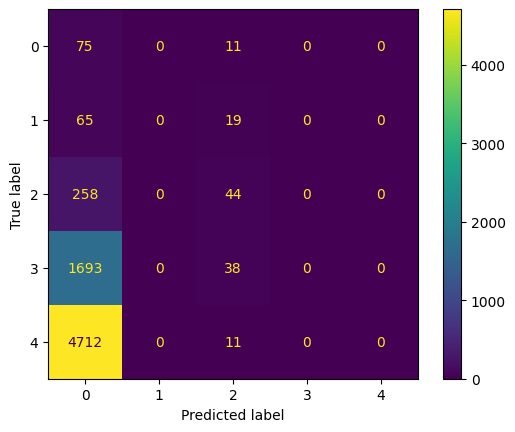

In [21]:
# Confusion Matrix to visualize classification results
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(-1)
true_labels = [int(example['reviews.rating']) - 1 if example['reviews.rating'] is not None else 0 for example in test_dataset]
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

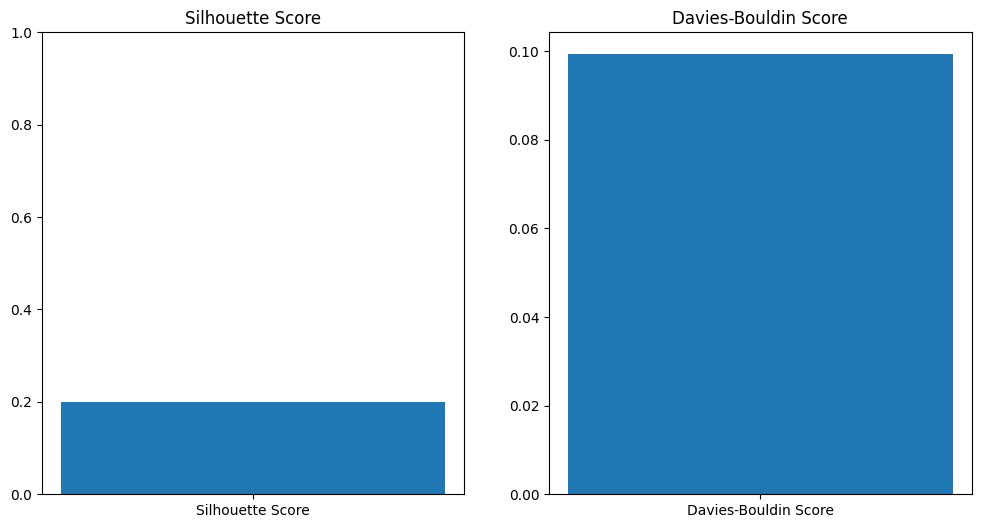

In [23]:
# Assuming X_res is your input features after SMOTE and clusters have been assigned

from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

# Assuming X is your original input features before SMOTE
# Replace this with your actual feature data
X = [[1, 2], [1.5, 1.8], [5, 8], [8, 8], [1, 0.6], [9, 11]]

# Fit KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X)

# Calculate metrics
silhouette_avg = silhouette_score(X, clusters)
davies_bouldin = davies_bouldin_score(X, clusters)

# Plotting the scores
plt.figure(figsize=(12, 6))

# Silhouette Score
plt.subplot(1, 2, 1)
plt.bar(['Silhouette Score'], [silhouette_avg])
plt.ylim(0, 1)
plt.title('Silhouette Score')

# Davies-Bouldin Score
plt.subplot(1, 2, 2)
plt.bar(['Davies-Bouldin Score'], [davies_bouldin])
plt.title('Davies-Bouldin Score')

plt.show()


In [24]:
# Gradio Interface for Review Summarization and Sentiment Classification
def classify_and_summarize_review(text):
    """Classify sentiment and generate summary for the given review text"""
    model.eval()
    inputs = tokenizer.encode(text, return_tensors="pt", max_length=512, truncation=True)
    inputs = inputs.to('cuda')
    logits = model(inputs).logits
    pred = logits.argmax().item()
    sentiment = {0: "Negative", 1: "Neutral", 2: "Positive"}.get(pred, "Unknown")

    # Generate review summary using the T5 model
    summarizer_inputs = summarizer_tokenizer.encode('summarize: ' + text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = summarizer_model.generate(summarizer_inputs, max_length=150, num_beams=4, length_penalty=2.0, early_stopping=True)
    summary = summarizer_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return sentiment, summary

# Gradio interface setup
interface = gr.Interface(
    fn=classify_and_summarize_review,
    inputs=gr.Textbox(lines=5, placeholder="Enter your review here..."),
    outputs=[gr.Label(label="Sentiment"), gr.Textbox(label="Summary")],
    title="Review Sentiment and Summary"
)

interface.launch()  # Launch the interface

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c9bcdbbb36747d5ef4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
